## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from image import *
import csv  
from io import BytesIO
from IPython import display

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

import torch
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
from ML_helper import *

from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import h5py

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
data = np.load('images.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)


model = tf.keras.models.load_model('stringlookups.h5');

char_to_num = model.layers[0]
num_to_char = model.layers[1]

In [3]:
padding_token = 99




In [4]:
h5f = h5py.File(('dataset.h5'), 'r')

num_samples, image_height, image_width = h5f['images'].shape
max_len = h5f['labels'].shape[1]


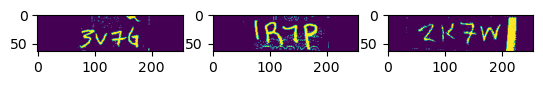

In [5]:
fig,ax = plt.subplots(1,3)

for i in range(3):
    ax[i].imshow(h5f['images'][i])


In [6]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model(lr):
    # Inputs to the model
    input_img = keras.Input(shape=(image_height, image_width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    # First conv block.
    # x = keras.layers.Conv2D(
    #     32,
    #     (3, 3),
    #     activation="relu",
    #     kernel_initializer="he_normal",
    #     padding="same",
    #     name="Conv2",
    # )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    # x = keras.layers.Conv2D(
    #     64,
    #     (3, 3),
    #     activation="relu",
    #     kernel_initializer="he_normal",
    #     padding="same",
    #     name="Conv4",
    # )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # # Second conv block.
    # x = keras.layers.Conv2D(
    #     64,
    #     (3, 3),
    #     activation="relu",
    #     kernel_initializer="he_normal",
    #     padding="same",
    #     name="Conv5",
    # )(x)
    # x = keras.layers.Conv2D(
    #     64,
    #     (3, 3),
    #     activation="relu",
    #     kernel_initializer="he_normal",
    #     padding="same",
    #     name="Conv6",
    # )(x)
    # x = keras.layers.MaxPooling2D((2, 2), name="pool3")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_height // 4), (image_width // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    # x = keras.layers.Dense(64, activation="relu", name="dense1.5")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)





    allchars = char_to_num.get_vocabulary()

    num_letters = len([c for c in allchars if c.isalpha()])
    num_numbers = num_letters#len(allchars) - num_letters
   
    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    
    # letters = keras.layers.Dense(64, activation="relu", name="denselets1")(x)
    
    letters = keras.layers.Dense(
        num_letters + 1, activation="softmax", name="denselets2"
    )(x)


    # numbers = keras.layers.Dense(64, activation="relu", name="densenums1")(x)

    numbers = keras.layers.Dense(
        num_numbers + 1, activation="softmax", name="densenums2"
    )(x)


    letters = letters[:,:4] #we can have max 4 letters or numbers in string (assuming maximum 8)
    numbers = numbers[:,:4]

    letters = tf.concat([letters, tf.zeros([tf.shape(letters)[0], tf.shape(letters)[1], num_numbers+2])], axis=2)
    numbers = tf.concat([tf.zeros([tf.shape(numbers)[0], tf.shape(numbers)[1], num_letters+2]), numbers ], axis=2)

    x = keras.layers.Concatenate(axis=1, name='concatter')([numbers[:,:1], letters[:,:1], numbers[:,1:2], letters[:,1:2], numbers[:,2:3], letters[:,2:3], numbers[:,3:4], letters[:,3:4]] )

    # x = tf.stack([numbers[:,0], letters[:,0], numbers[:,1], letters[:,1], numbers[:,1], letters[:,2], numbers[:,2], letters[:,3], numbers[:,3]], axis=1)  
    

    # # Add CTC layer for calculating CTC loss at each step.
    # output = CTCLayer(name="ctc_loss")(labels, x)

    # # # Define the model.
    # model = keras.models.Model(
    #     inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")
    # )

    model = keras.models.Model(inputs=input_img, outputs=x, name="handwriting_recognizer")

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    # Optimizer.
    opt = keras.optimizers.Adam(lr = lr)
    # Compile the model and return.
    model.compile(optimizer=opt, loss=loss)
    # model.compile(optimizer=opt)
    return model




lr = 3e-3

# Get the model.
model = build_model(lr)
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 256, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 32, 128, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv3 (Conv2D)                 (None, 32, 128, 64)  18496       ['pool1[0][0

c:\Users\howards\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
batch_size=32

datause = 1

train_test_split = 0.85

idxs = np.arange(num_samples)

train_idxs = idxs[:int(len(idxs) * datause * train_test_split)]
test_idxs = idxs[int(len(idxs)*datause * train_test_split):]

train_dl = DataGenerator(h5f, train_idxs, batch_size=batch_size)
val_dl = DataGenerator(h5f, train_idxs, batch_size=batch_size)

# train_ds = prepare_dataset(h5f, train_idxs)
# val_ds = prepare_dataset(h5f, test_idxs)

In [8]:
validation_images = []
validation_labels = []

for batch in val_dl:
    # validation_images.append(batch['image'])
    # validation_labels.append(batch['label'])
    validation_images.append(batch[0])
    validation_labels.append(batch[1])


def calculate_edit_distance(labels, predictions):
    # # Get a single batch and convert its labels to sparse tensors.
    # saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # # Make predictions and convert them to sparse tensors.
    # input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    # predictions_decoded = keras.backend.ctc_decode(
    #     predictions, input_length=input_len, greedy=True
    # )[0][0][:, :max_len]
    # sparse_predictions = tf.cast(
    #     tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    # )


    # Compute individual edit distances and average them out.
    # edit_distances = tf.edit_distance(
    #     predictions, labels, normalize=False
    # )

    
    
    predictions = greedy(predictions)


    edit_distances = np.abs(labels - predictions)

    return tf.reduce_sum(edit_distances) / predictions.shape[0]

def greedy(x):
    idx = np.argmax(x, axis=2) #this contains the 8 chracters fir each image
    a = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            a[i,j,idx[i,j]] = 1

    return a




class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i], verbose =0)
            print(predictions.shape)
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [9]:
epochs = 50  # To get good results this should be at least 50.

model = build_model(lr =1e-4)
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="concatter").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_dl,
    validation_data=val_dl,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/50


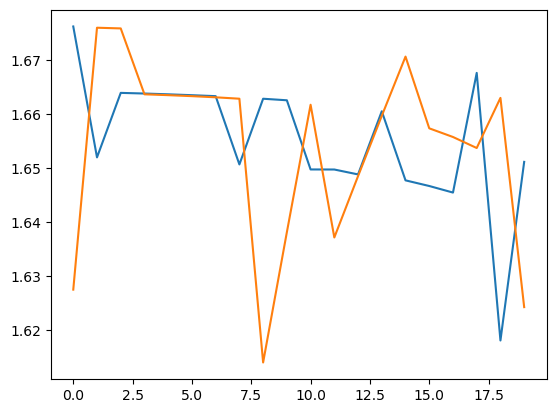

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

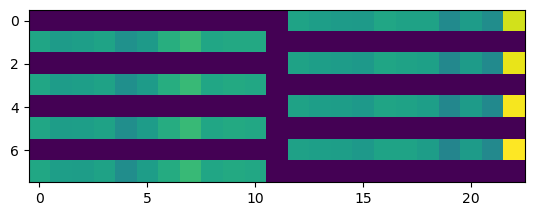

In [ ]:
plt.imshow(preds[0])

1/1 [==============================] - 0s 96ms/step


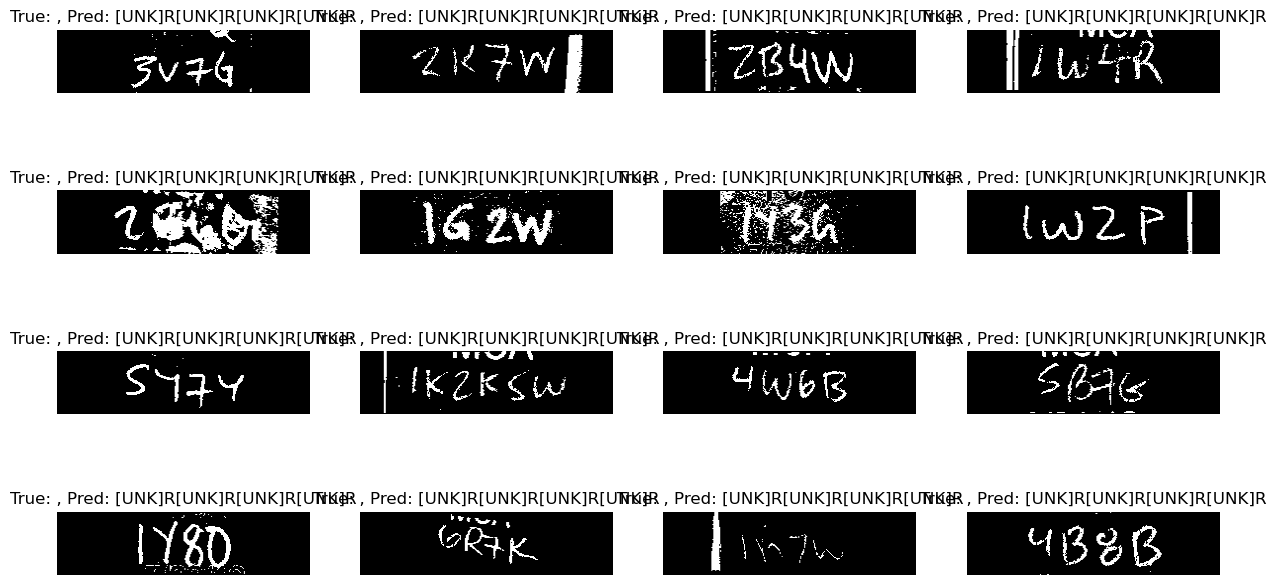

In [ ]:
def decode_batch_predictions(pred):
    # input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # # Use greedy search. For complex tasks, you can use beam search.
    # results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
    #     :, :max_len
    # ]

   

    # Iterate over the results and get back the text.
    output = decode_vectorized_label(pred)
    return output
    

def decode_vectorized_label(results):

    results = np.argmax(results,axis=2)
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text



#  Let's check results on some test samples.
batch = train_dl[0]
# batch_images = batch["image"]
# batch_labels = batch["label"]
batch_images = batch[0]
batch_labels = batch[1]
_, ax = plt.subplots(4, 4, figsize=(15, 8))

preds = prediction_model.predict(batch_images)
pred_texts = decode_batch_predictions(preds)
true_texts = decode_vectorized_label(batch_labels)

for i in range(16):
    img = batch_images[i]
    # img = tf.image.flip_left_right(img)
    # img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"True: {true_texts[i].split('[')[0]}, Pred: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")

plt.show()

1/1 [==============================] - 0s 65ms/step


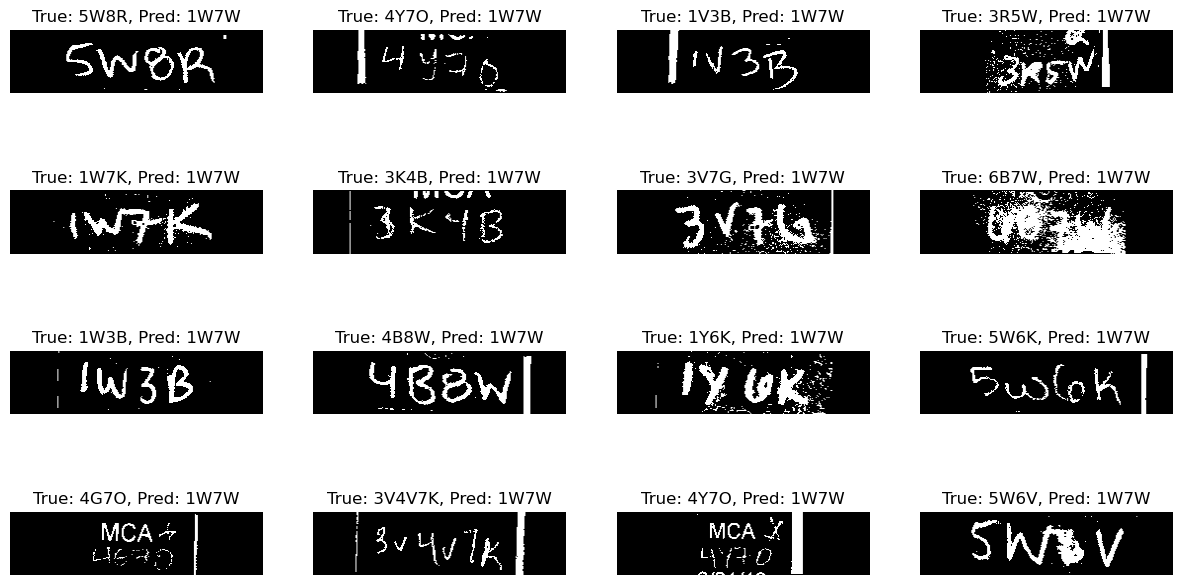

In [ ]:
#  Let's check results on some test samples.
batch = val_dl[1]
batch_images = batch["image"]
batch_labels = batch["label"]
_, ax = plt.subplots(4, 4, figsize=(15, 8))

preds = prediction_model.predict(batch_images)
pred_texts = decode_batch_predictions(preds)
true_texts = decode_vectorized_label(batch_labels)

for i in range(16):
    img = batch_images[i]
    # img = tf.image.flip_left_right(img)
    # img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"True: {true_texts[i].split('[')[0]}, Pred: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
